In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\Mahesh.Bhosale\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint


def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(forces, particles)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

In [3]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

In [4]:
from matplotlib import animation


def animate_pendulum(n):
    t = np.linspace(0, 10, 200)
    p = integrate_pendulum(n, t)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [5]:
anim = animate_pendulum(3)

C:\Users\Mahesh.Bhosale\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\sympy\physics\mechanics\kane.py:537: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


In [6]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [7]:
anim = animate_pendulum(5)
HTML(anim.to_html5_video())  # uncomment to embed

C:\Users\Mahesh.Bhosale\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\sympy\physics\mechanics\kane.py:537: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


In [10]:
from matplotlib import collections


def animate_pendulum_multiple(n, n_pendulums=41, perturbation=1E-6, track_length=15):
    oversample = 3
    track_length *= oversample
    
    t = np.linspace(0, 10, oversample * 200)
    p = [integrate_pendulum(n, t, initial_positions=135 + i * perturbation / n_pendulums)
         for i in range(n_pendulums)]
    positions = np.array([get_xy_coords(pi) for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    # positions is a 4D array: (npendulums, len(t), n+1, xy)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    track_segments = np.zeros((n_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow')
    tracks.set_array(np.linspace(0, 1, n_pendulums))
    ax.add_collection(tracks)
    
    points, = plt.plot([], [], 'ok')
    
    pendulum_segments = np.zeros((n_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((n_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((n_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim
    
anim = animate_pendulum_multiple(3)
HTML(anim.to_html5_video())  # uncomment to embed

C:\Users\Mahesh.Bhosale\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\sympy\physics\mechanics\kane.py:537: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [3]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


In [4]:
type(y)

pandas.core.series.Series

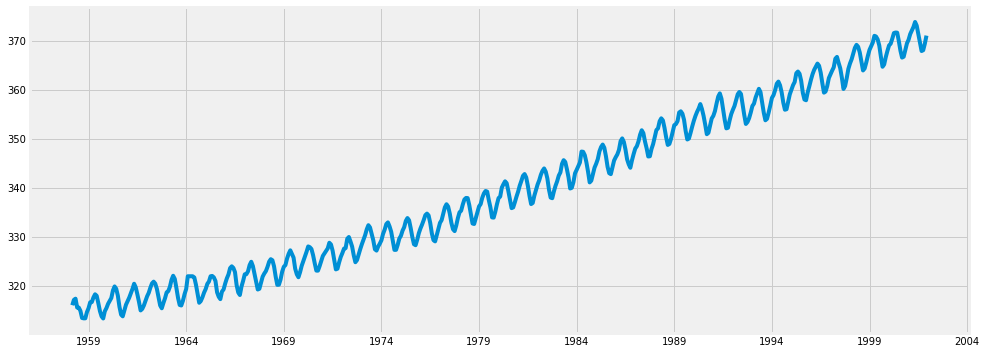

In [5]:
y.plot(figsize=(15, 6))
plt.show()

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343623902141
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727640915
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320021
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287839207805
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.65789780726
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912860043
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754598261
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327472809
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067304665
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716828834
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1105.710323856536
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4285479840107
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893641971
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.091298932857
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194094
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.7938547551238
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.950175782907
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.92837596466256
ARIMA

In [8]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3180      0.092      3.445      0.001       0.137       0.499
ma.L1         -0.6256      0.076     -8.182      0.000      -0.776      -0.476
ar.S.L12       0.0010      0.001      1.731      0.083      -0.000       0.002
ma.S.L12      -0.8765      0.026    -33.732      0.000      -0.927      -0.826
sigma2         0.0971      0.004     22.633      0.000       0.089       0.106


In [12]:
import pandas as pd

In [21]:
a = [10, 23, 34, 56,78,123, 345, 567, 234, 34, 56, 23]

In [24]:
len(a)

12

In [25]:
b = [1, 2, 3 ,4 ,5 ,6, 7, 8, 9, 10, 11, 12]

In [26]:
df = pd.DataFrame()
df['a'] = a
df['b'] = b

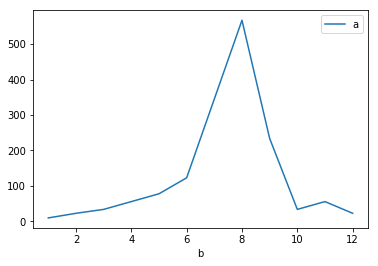

In [28]:
df.plot(x='b',y='a')

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
nn.Conv2d()

In [ ]:
nn.MaxPool2d()

In [ ]:
nn.Linear()

In [ ]:
F.relu()

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 512, 3)
        self.conv3 = nn.Conv2d(512, 1024, 3)
        self.fc1 = nn.Linear(1024 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
def prepare_data(download, transform, batch_size, num_workers):
    if transform:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=download, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=download, transform=transform)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=download)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=download)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, class_names

In [18]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader, classes = prepare_data(download=False, transform=transform, batch_size=4, num_workers=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
PATH = './cifar_net_5.pth'
torch.save(net.state_dict(), PATH)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

cpu
[1,  2000] loss: 2.170
[1,  4000] loss: 1.807
[1,  6000] loss: 1.663
[1,  8000] loss: 1.557
[1, 10000] loss: 1.504
[1, 12000] loss: 1.468
[2,  2000] loss: 1.397
[2,  4000] loss: 1.366
[2,  6000] loss: 1.336
[2,  8000] loss: 1.297
[2, 10000] loss: 1.315
[2, 12000] loss: 1.300
[3,  2000] loss: 1.223
[3,  4000] loss: 1.205
[3,  6000] loss: 1.193
[3,  8000] loss: 1.201
[3, 10000] loss: 1.197
[3, 12000] loss: 1.190
[4,  2000] loss: 1.120
[4,  4000] loss: 1.117
[4,  6000] loss: 1.099
[4,  8000] loss: 1.101
[4, 10000] loss: 1.100
[4, 12000] loss: 1.095
[5,  2000] loss: 1.019
[5,  4000] loss: 1.039
[5,  6000] loss: 1.026
[5,  8000] loss: 1.046
[5, 10000] loss: 1.029
[5, 12000] loss: 1.053
Finished Training
Accuracy of the network on the 10000 test images: 60 %


In [20]:
saved_net = Net()
saved_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
for name, module in saved_net.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

In [44]:
print(dict(saved_net.named_buffers()).keys())

dict_keys(['conv1.weight_mask', 'conv2.weight_mask', 'fc1.weight_mask', 'fc2.weight_mask', 'fc3.weight_mask'])


In [52]:
PATH = './cifar_net_5_pruned.pth'
torch.save(saved_net.state_dict(), PATH)

In [51]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = saved_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [50]:
for name, module in saved_net.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        prune.remove(module, 'weight')

In [1]:
import os

In [54]:
PATH='./cifar_net_5.pth'

In [55]:
stats = os.stat(PATH)
print('Size of file is', stats.st_size, 'bytes')

Size of file is 251391 bytes


In [56]:
PRUNE_PATH='./cifar_net_5_pruned.pth'
stats = os.stat(PRUNE_PATH)
print('Size of file is', stats.st_size, 'bytes')

Size of file is 251391 bytes


In [68]:
import zipfile

In [69]:
with ZipFile('pruned_cifarnet_5.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zipObj2:
    zipObj2.write(PRUNE_PATH)

In [70]:
with ZipFile('cifarnet_5.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zipObj2:
    zipObj2.write(PATH)

In [71]:
stats = os.stat('pruned_cifarnet_5.zip')
print('Size of file is', stats.st_size, 'bytes')

Size of file is 163314 bytes


In [4]:
stats = os.stat('cifarnet_5.zip')
stats.st_size/1024

226.4052734375

In [18]:
a = [i for i in range(1, 10, 1)]
b = [i for i in range(1, 18, 2)]
c = [i for i in range(1, 27, 3)]

In [19]:
a, b, c

([1, 2, 3, 4, 5, 6, 7, 8, 9],
 [1, 3, 5, 7, 9, 11, 13, 15, 17],
 [1, 4, 7, 10, 13, 16, 19, 22, 25])

In [13]:
import matplotlib.pyplot as plt

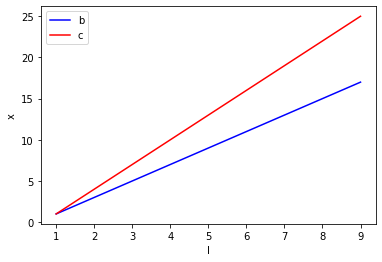

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(xlabel='l', ylabel='x')
ax1.plot(a, b, c='b', label='b')
ax1.plot(a, c, c='r', label='c')
plt.legend(loc='upper left');
plt.show()

In [36]:
import time
t = time.time()

In [37]:
print(time.time() - t)

2.6771328449249268
